In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score, average_precision_score, precision_recall_curve, roc_curve, make_scorer
import seaborn as sns
import requests
from sklearn import preprocessing
import os
!pip install python-igraph
import networkx as nx
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import sys
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils import compute_sample_weight
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score




In [2]:
data = pd.read_csv("Creditcard.csv")
data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [3]:

X = data.drop(columns=["Class"])
y = data["Class"]

#Train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train/validation split withing the trainingset
X_train, X_val, y_train_true, y_val_true = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

# PU-engineering on the trainingset
def maak_pu_setting(y_true, label_ratio=0.2, random_state=42):
    np.random.seed(random_state)
    positieve_indexen = np.where(y_true == 1)[0]
    n_gelabeld = int(label_ratio * len(positieve_indexen))
    gelabelde_indexen = np.random.choice(positieve_indexen, size=n_gelabeld, replace=False)
    
    y_pu = np.zeros_like(y_true)
    y_pu[gelabelde_indexen] = 1
    
    return y_pu, y_true, gelabelde_indexen

y_train_pu, y_train_true, gelabelde_indexen = maak_pu_setting(y_train_true, label_ratio=0.2)



                                                                            
                                                                              



In [4]:
print(X_test)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .

[I 2025-05-13 21:01:24,758] A new study created in memory with name: no-name-9e86c777-2104-487b-940e-59b91bf44cd3
[I 2025-05-13 21:01:27,389] Trial 0 finished with value: 0.4893617021276595 and parameters: {'n_estimators': 180, 'max_depth': 3, 'learning_rate': 0.06723234414703849, 'subsample': 0.8892006513591346, 'colsample_bytree': 0.8527452101936028, 'gamma': 2.091166032713354, 'reg_alpha': 2.2841845716063247, 'reg_lambda': 0.9669988458193168, 'scale_pos_weight': 19.787917477373863}. Best is trial 0 with value: 0.4893617021276595.
[I 2025-05-13 21:01:30,385] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 515, 'max_depth': 6, 'learning_rate': 0.18474801346779451, 'subsample': 0.8869215774618909, 'colsample_bytree': 0.7122464281336676, 'gamma': 2.691509194231148, 'reg_alpha': 8.982726987696383, 'reg_lambda': 4.744046729204903, 'scale_pos_weight': 1.2038131245951185}. Best is trial 0 with value: 0.4893617021276595.
[I 2025-05-13 21:01:34,990] Trial 2 finished with val

[I 2025-05-13 21:02:51,244] Trial 20 finished with value: 0.6542056074766355 and parameters: {'n_estimators': 476, 'max_depth': 4, 'learning_rate': 0.010168824583565056, 'subsample': 0.6732842176304671, 'colsample_bytree': 0.9636934540740448, 'gamma': 0.1909352005726932, 'reg_alpha': 5.498987381572432, 'reg_lambda': 8.28315330281032, 'scale_pos_weight': 12.028113356183827}. Best is trial 6 with value: 0.7413793103448276.
[I 2025-05-13 21:02:57,020] Trial 21 finished with value: 0.7079646017699115 and parameters: {'n_estimators': 595, 'max_depth': 3, 'learning_rate': 0.015617178065013457, 'subsample': 0.985976027806257, 'colsample_bytree': 0.8860322691647451, 'gamma': 4.539903534294001, 'reg_alpha': 3.7920792818729323, 'reg_lambda': 2.4981101898767912, 'scale_pos_weight': 16.931843198482532}. Best is trial 6 with value: 0.7413793103448276.
[I 2025-05-13 21:03:02,527] Trial 22 finished with value: 0.7192982456140351 and parameters: {'n_estimators': 597, 'max_depth': 3, 'learning_rate': 0

[I 2025-05-13 21:03:57,832] Trial 40 finished with value: 0.4090909090909091 and parameters: {'n_estimators': 303, 'max_depth': 4, 'learning_rate': 0.11358419772950736, 'subsample': 0.9666189505575726, 'colsample_bytree': 0.8450311320581047, 'gamma': 1.8178926486642828, 'reg_alpha': 1.9893292529573383, 'reg_lambda': 7.999143283782231, 'scale_pos_weight': 9.474637793999735}. Best is trial 29 with value: 0.8031496062992126.
[I 2025-05-13 21:04:00,336] Trial 41 finished with value: 0.7839999999999999 and parameters: {'n_estimators': 241, 'max_depth': 3, 'learning_rate': 0.028527345389138262, 'subsample': 0.9209053378214237, 'colsample_bytree': 0.9998910892842038, 'gamma': 2.85491900972112, 'reg_alpha': 4.432706537263393, 'reg_lambda': 6.5326186539958195, 'scale_pos_weight': 17.96704393021703}. Best is trial 29 with value: 0.8031496062992126.
[I 2025-05-13 21:04:02,908] Trial 42 finished with value: 0.7731092436974789 and parameters: {'n_estimators': 233, 'max_depth': 3, 'learning_rate': 0

[I 2025-05-13 21:04:48,327] Trial 60 finished with value: 0.7540983606557377 and parameters: {'n_estimators': 161, 'max_depth': 5, 'learning_rate': 0.02594551145218759, 'subsample': 0.9789301454390447, 'colsample_bytree': 0.8855924390329933, 'gamma': 2.779240902632477, 'reg_alpha': 6.5490475021154655, 'reg_lambda': 7.246385784808262, 'scale_pos_weight': 18.524377772657658}. Best is trial 29 with value: 0.8031496062992126.
[I 2025-05-13 21:04:50,587] Trial 61 finished with value: 0.7741935483870968 and parameters: {'n_estimators': 210, 'max_depth': 3, 'learning_rate': 0.028381682718017862, 'subsample': 0.9421406500605876, 'colsample_bytree': 0.9537328300694492, 'gamma': 2.5145956409355, 'reg_alpha': 4.59428537756964, 'reg_lambda': 9.40256500917872, 'scale_pos_weight': 17.67954833301674}. Best is trial 29 with value: 0.8031496062992126.
[I 2025-05-13 21:04:52,600] Trial 62 finished with value: 0.8031496062992126 and parameters: {'n_estimators': 191, 'max_depth': 3, 'learning_rate': 0.020

[I 2025-05-13 21:05:37,663] Trial 80 finished with value: 0.7936507936507936 and parameters: {'n_estimators': 283, 'max_depth': 3, 'learning_rate': 0.020787651564938052, 'subsample': 0.8791224905741507, 'colsample_bytree': 0.9338185910509799, 'gamma': 2.5414620982907152, 'reg_alpha': 2.3559056392882813, 'reg_lambda': 8.165732907551774, 'scale_pos_weight': 19.038412154931745}. Best is trial 63 with value: 0.8124999999999999.
[I 2025-05-13 21:05:40,142] Trial 81 finished with value: 0.8031496062992126 and parameters: {'n_estimators': 227, 'max_depth': 3, 'learning_rate': 0.015827709764128773, 'subsample': 0.7626931905187948, 'colsample_bytree': 0.9070016938979266, 'gamma': 2.316033527340828, 'reg_alpha': 0.27440106506746453, 'reg_lambda': 6.862039389716006, 'scale_pos_weight': 19.998897430819103}. Best is trial 63 with value: 0.8124999999999999.
[I 2025-05-13 21:05:42,515] Trial 82 finished with value: 0.7936507936507936 and parameters: {'n_estimators': 239, 'max_depth': 3, 'learning_rat

Beste hyperparameters: {'n_estimators': 187, 'max_depth': 3, 'learning_rate': 0.021544067633632976, 'subsample': 0.8790647418779485, 'colsample_bytree': 0.9737960458982016, 'gamma': 2.0189592309305664, 'reg_alpha': 2.5706599052509835, 'reg_lambda': 8.22513557134872, 'scale_pos_weight': 19.367608713615304}
Beste threshold (voor F1): 0.2909
Model evaluatie (gewogen + getuned + threshold-optimalisatie):
Accuracy: 0.9993
Precision: 0.8409
Recall: 0.7500
F1-score: 0.7929
ROC AUC: 0.9562
PR AUC: 0.6774


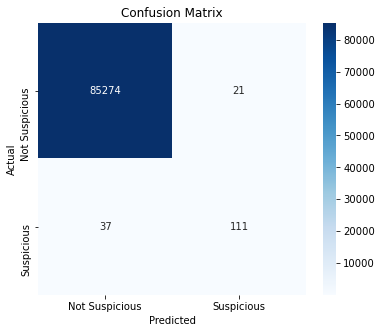

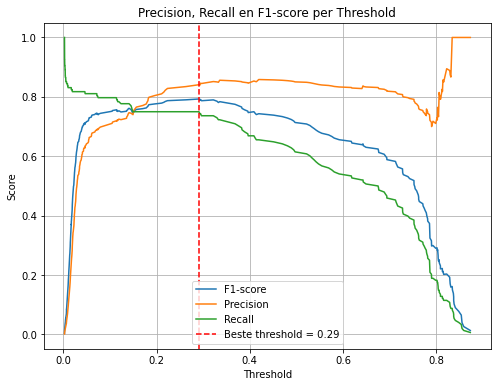

In [5]:
#OPTUNA hyperparameter tuning

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "use_label_encoder": False,
        "tree_method": "hist",
        "n_estimators": trial.suggest_int("n_estimators", 50, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "learning_rate": trial.suggest_float("learning_rate", 0.0004, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 20.0)
    }
    
    model = XGBClassifier(**params)

    # Train on PU-labels
    model.fit(X_train, y_train_pu)

    # predict on the validation set
    y_val_pred = model.predict(X_val)

    # calculate F1 on real labels
    score = f1_score(y_val_true, y_val_pred)

    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=1200)

print("Beste hyperparameters:", study.best_params)

#Use the best model
best_params = study.best_params
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "use_label_encoder": False,
    "tree_method": "hist"
})
xgb_best = XGBClassifier(**best_params)
xgb_best.fit(X_train, y_train_pu)  


y_proba = xgb_best.predict_proba(X_test)[:, 1]

# threshold tuning based on F1
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print(f"Beste threshold (voor F1): {best_thresh:.4f}")

# prediction
y_pred = (y_proba >= best_thresh).astype(int)

# evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print("Model evaluatie (gewogen + getuned + threshold-optimalisatie):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# Confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['Not Suspicious', 'Suspicious'],
    yticklabels=['Not Suspicious', 'Suspicious']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


plt.figure(figsize=(8,6))
plt.plot(thresholds, f1_scores[:-1], label="F1-score")
plt.plot(thresholds, prec[:-1], label="Precision")
plt.plot(thresholds, rec[:-1], label="Recall")
plt.axvline(x=best_thresh, color='r', linestyle='--', label=f'Beste threshold = {best_thresh:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall en F1-score per Threshold")
plt.legend()
plt.grid()

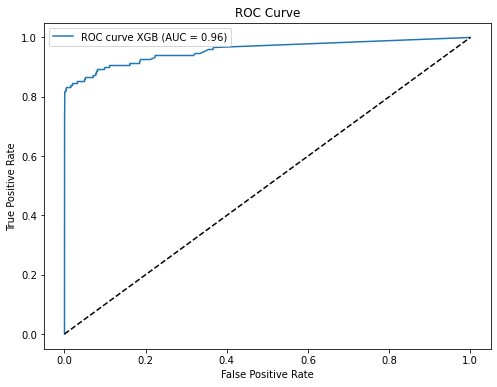

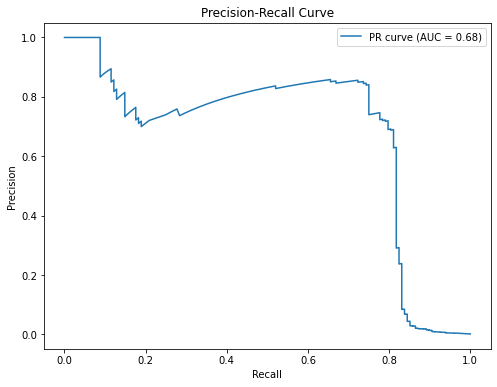

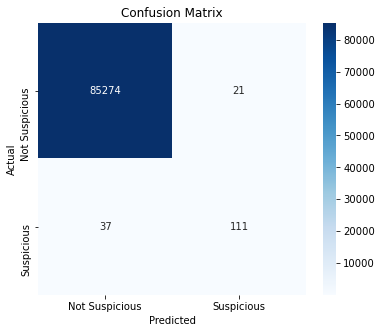

In [6]:
#Beste hyperparameters: {'n_estimators': 187, 'max_depth': 3, 'learning_rate': 0.021544067633632976, 
#'subsample': 0.8790647418779485, 'colsample_bytree': 0.9737960458982016, 'gamma': 2.0189592309305664, 
#'reg_alpha': 2.5706599052509835, 'reg_lambda': 8.22513557134872, 'scale_pos_weight': 19.367608713615304}

#  ROC Curve 
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve XGB (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

#  visualizing the Confusion Matrix 
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Suspicious', 'Suspicious'], yticklabels=['Not Suspicious', 'Suspicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [9]:
np.save("preds_XGB(FRAUDE).npy", y_pred)

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

fpr_pu, tpr_pu, _ = roc_curve(y_test, y_proba)
auc_pu = roc_auc_score(y_test, y_proba)

np.savez("roc_XGB.npz",
         fpr=fpr_pu,
         tpr=tpr_pu,
         auc=auc_pu,
         labels=y_test,
         scores=y_proba)
